<a href="https://colab.research.google.com/github/AtharvanDogra/Twitter-Stance-Detection/blob/main/Seq_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install datasets
# !pip install wandb
# !pip3 install nltk emoji==0.6.0

In [ ]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer


tokenizer = TweetTokenizer()


def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token


def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        # .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())


if __name__ == "__main__":
    print(
        normalizeTweet(
            "SC has first two presumptive cases of coronavirus, DHEC confirms https://postandcourier.com/health/covid19/sc-has-first-two-presumptive-cases-of-coronavirus-dhec-confirms/article_bddfe4ae-5fd3-11ea-9ce4-5f495366cee6.html?utm_medium=social&utm_source=twitter&utm_campaign=user-share… via @postandcourier"
        )
    )

SC has first two presumptive cases of coronavirus , DHEC confirms HTTPURL ... via @USER


In [ ]:
import pandas as pd
import datasets
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification,Trainer, TrainingArguments,BertForSequenceClassification,BertTokenizerFast, AutoModelForSequenceClassification,AutoTokenizer
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
# import wandb
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams
from transformers.optimization import Adafactor, AdafactorSchedule

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Atharvan_Workspace/IRMiDis FIRE2022/vax_train.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


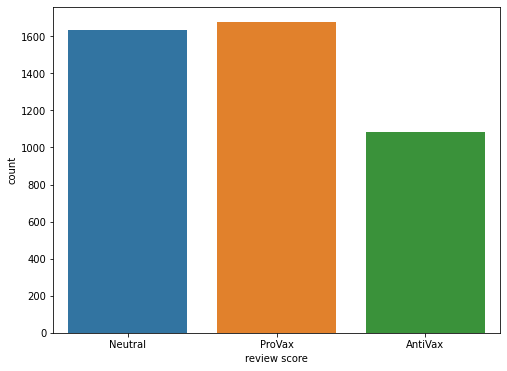

In [ ]:
rcParams['figure.figsize'] = 8, 6
sns.countplot(df.label)
plt.xlabel('review score');

In [ ]:
def sentiment2label(label):
    if label == "Neutral":
        return 0
    elif label == "ProVax" :
        return 1
    else: 
        return 2

df['label'] = df['label'].apply(sentiment2label)
# df['tweet'] = df['tweet'].apply(normalizeToken)
# df['tweet'] = df['tweet'].apply(normalizeTweet)

In [ ]:
df = datasets.Dataset.from_pandas(df[['tweet', 'label']])
df_splitted = df.train_test_split(test_size=0.2, shuffle=True)
train = df_splitted['train']
test = df_splitted['test']

In [ ]:
# test.save_to_disk('/content/drive/MyDrive/Atharvan_Workspace/IRMiDis FIRE2022/final')
# load_from_disk('/content/drive/MyDrive/Atharvan_Workspace/IRMiDis FIRE2022/final')

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# model = AutoModelForSequenceClassification.from_pretrained('vinai/bertweet-covid19-base-cased', num_labels=3)
# tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-covid19-base-cased', max_length = 512)
model = AutoModelForSequenceClassification.from_pretrained('digitalepidemiologylab/covid-twitter-bert-v2', num_labels=3, hidden_dropout_prob=0.3)
tokenizer = AutoTokenizer.from_pretrained('digitalepidemiologylab/covid-twitter-bert-v2', max_length = 512)

Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClass

In [ ]:
model.to('cuda')

In [ ]:
# tokenizer.save_pretrained('/content/drive/MyDrive/Atharvan_Workspace/IRMiDis FIRE2022/final')

('/content/drive/MyDrive/Atharvan_Workspace/IRMiDis FIRE2022/final/tokenizer_config.json',
 '/content/drive/MyDrive/Atharvan_Workspace/IRMiDis FIRE2022/final/special_tokens_map.json',
 '/content/drive/MyDrive/Atharvan_Workspace/IRMiDis FIRE2022/final/vocab.json',
 '/content/drive/MyDrive/Atharvan_Workspace/IRMiDis FIRE2022/final/merges.txt',
 '/content/drive/MyDrive/Atharvan_Workspace/IRMiDis FIRE2022/final/added_tokens.json',
 '/content/drive/MyDrive/Atharvan_Workspace/IRMiDis FIRE2022/final/tokenizer.json')

In [ ]:
def tokenization(batched_text):
    return tokenizer(batched_text['tweet'], padding = True, truncation=True)


train_data = train.map(tokenization, batched = True, batch_size = len(train))
test_data = test.map(tokenization, batched = True, batch_size = len(test))

  0%|          | 0/1 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
train_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
training_args = TrainingArguments(
    output_dir = '/content/drive/MyDrive/Atharvan_Workspace/IRMiDis FIRE2022/final/ctbertpr',
    num_train_epochs=15,
    per_device_train_batch_size = 8,
    # gradient_accumulation_steps = 16,    
    per_device_eval_batch_size= 8,
    save_strategy="epoch",
    evaluation_strategy = "epoch",
    load_best_model_at_end=True,
    # warmup_steps=500,
    # weight_decay=0.01,
    logging_steps = 8,
    # fp16 = True,
    logging_dir='/content/drive/MyDrive/Atharvan_Workspace/IRMiDis FIRE2022/final/ctbertpr',
    # dataloader_num_workers = 8,
    run_name = 'ctbert-classification',
    # save_total_limit = 2,
)

In [ ]:
from transformers.optimization import Adafactor, AdafactorSchedule
from transformers import get_cosine_schedule_with_warmup
optimizer = Adafactor(model.parameters(), scale_parameter=False, relative_step=False,  lr=2e-5)
# optimizer = Adafactor(model.parameters(), scale_parameter=False, relative_step=False, warmup_init=False, lr=None)
# lr_scheduler = AdafactorSchedule(optimizer)
# optimizer = Adafactor(model.parameters(), scale_parameter=True, relative_step=False, warmup_init=False,, lr=8e-5, weight_decay=0.002)

# optimizer = Adafactor(model.parameters(), scale_parameter=True, relative_step=False, lr=3e-5, weight_decay=0.002)
# lr_scheduler = get_cosine_schedule_with_warmup(optimizer = optimizer, num_training_steps=15, num_warmup_steps=3)

In [ ]:
from typing import Dict, Union

class MyTrainer(Trainer):
    def log(self, logs: Dict[str, float]) -> None:
        logs["learning_rate"] = self._get_learning_rate()
        super().log(logs)

In [ ]:
trainer = MyTrainer(
    model=model,
    optimizers= (optimizer,None),
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=test_data,
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet. If tweet are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 3513
  Num Epochs = 15
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6600


Epoch,Training Loss,Validation Loss


In [ ]:
trainer.predict(test_data)